run this notebook with the `gayles` conda environment

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyC')

In [3]:
ant = '../../models/Antimony/TopologyC_1.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.1827489929340788e-13

In [4]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [5]:
data_file01 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_0.1.csv'
data_file02 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_0.2.csv'
data_file03 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_0.3.csv'
data_file04 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_0.4.csv'
data_file05 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_0.5.csv'

data_file15 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_1.5.csv'
data_file3 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_3.csv'
data_file5 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_5.csv'
data_file7 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_7.csv'
data_file100 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_10.csv'

In [108]:
BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data_file02, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data_file03, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data_file04, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data_file3, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data_file5, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data_file7, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data_file100, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


## Running ADVI

In [8]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 75000 #150000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-2), 
            total_grad_norm_constraint=1,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(1000)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.0378e+06
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4.6918e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.5186e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


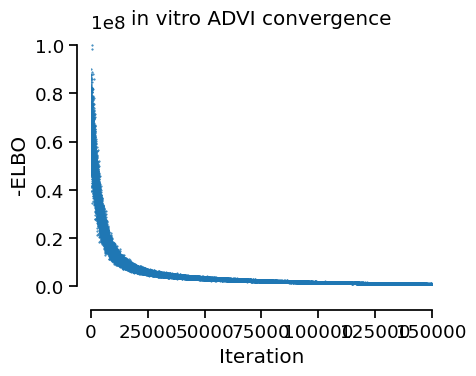

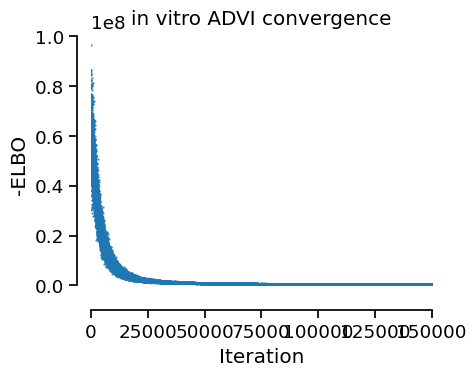

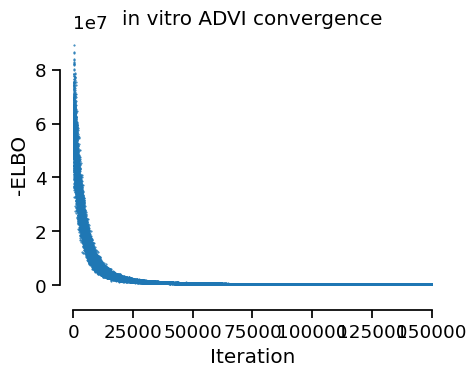

In [11]:
trace01, ppc01 = run_ADVI(BMCA_obj01)
trace03, ppc03 = run_ADVI(BMCA_obj03)
trace05, ppc05 = run_ADVI(BMCA_obj05)



In [14]:
with gzip.open("../../data/results/tracePickles/topologyC-alldata_1-5.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace03":trace03,
                "trace05":trace05,

                "ppc01":ppc01,
                "ppc03":ppc03,
                "ppc05":ppc05
                },
                f,
            )

In [15]:
trace01, ppc01 = 0, 0
trace03, ppc03 = 0, 0
trace05, ppc05 = 0, 0

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 75,179
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 77,386
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


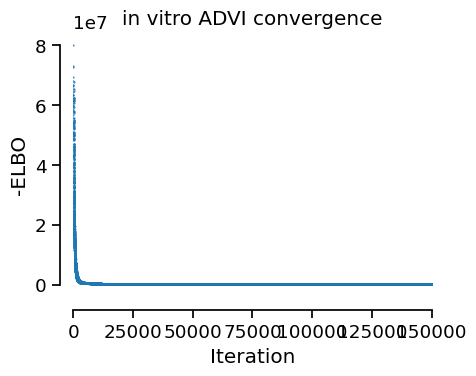

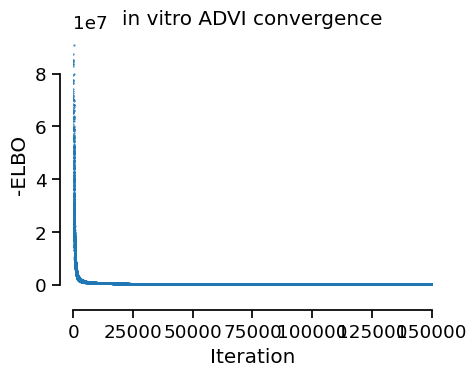

In [9]:
trace15, ppc15 = run_ADVI(BMCA_obj15)
trace3, ppc3 = run_ADVI(BMCA_obj3)


In [10]:
with gzip.open("../../data/results/tracePickles/topologyC-alldata_15-3.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace15":trace15,
                "trace3":trace3,
                "ppc15":ppc15,
                "ppc3":ppc3,
                },
                f,
            )

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.7184e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.2112e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.1105e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


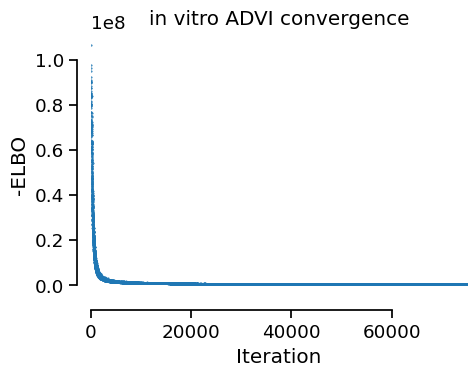

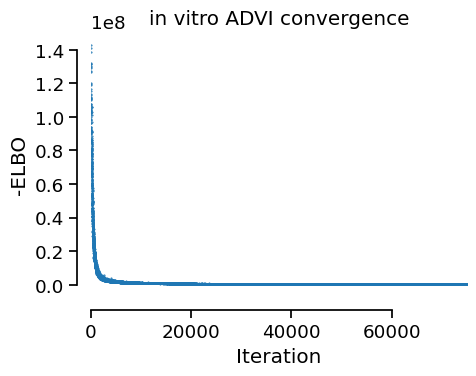

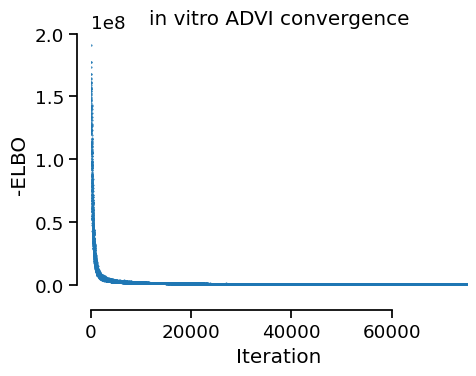

In [9]:
trace5, ppc5 = run_ADVI(BMCA_obj5)
trace7, ppc7 = run_ADVI(BMCA_obj7)
trace100, ppc100 = run_ADVI(BMCA_obj100)

In [10]:
with gzip.open("../../data/results/tracePickles/topologyC-alldata_5-10.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100,
                "ppc5":ppc5,
                "ppc7":ppc7,
                "ppc100":ppc100
                },
                f,
            )

## Analysis

In [7]:
picklefolder = '../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyC-alldata_1-5.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace01=traces['trace01']
#trace02=traces['trace02']
trace03=traces['trace03']
#trace04=traces['trace04']
trace05=traces['trace05']

ppc01=traces['ppc01']
#ppc02=traces['ppc02']
ppc03=traces['ppc03']
#ppc04=traces['ppc04']
ppc05=traces['ppc05']

In [8]:
with gzip.open(picklefolder + 'topologyC-alldata_15-3.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace15=traces['trace15']
trace3=traces['trace3']

ppc15=traces['ppc15']
ppc3=traces['ppc3']

In [9]:
with gzip.open(picklefolder + 'topologyC-alldata_5-10.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

ppc5=traces['ppc5']
ppc7=traces['ppc7']
ppc100=traces['ppc100']

In [109]:
bmca_objs = [BMCA_obj01,BMCA_obj03,BMCA_obj05,BMCA_obj15,BMCA_obj3,BMCA_obj5,BMCA_obj7,BMCA_obj100]
pt_labels = ['0.1x', '0.3x', '0.5x', '1.5x', '3x', '5x', '7x', '10x']
pt_levels = [float(i[:-1]) for i in pt_labels]

#### Known flux and metabolite concentrations check

In [11]:
v_ppc_01 = az.summary(ppc01['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_03 = az.summary(ppc03['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_05 = az.summary(ppc05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_15 = az.summary(ppc15['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_3 = az.summary(ppc3['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_5 = az.summary(ppc5['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_7 = az.summary(ppc7['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_100 = az.summary(ppc100['posterior_predictive']['v_hat_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [12]:
x_ppc_01 = az.summary(ppc01['posterior_predictive']['chi_obs'])['mean']
x_ppc_03 = az.summary(ppc03['posterior_predictive']['chi_obs'])['mean']
x_ppc_05 = az.summary(ppc05['posterior_predictive']['chi_obs'])['mean']
x_ppc_15 = az.summary(ppc15['posterior_predictive']['chi_obs'])['mean']
x_ppc_3 = az.summary(ppc3['posterior_predictive']['chi_obs'])['mean']
x_ppc_5 = az.summary(ppc5['posterior_predictive']['chi_obs'])['mean']
x_ppc_7 = az.summary(ppc7['posterior_predictive']['chi_obs'])['mean']
x_ppc_100 = az.summary(ppc100['posterior_predictive']['chi_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [13]:
e_ppc_01 = az.summary(ppc01['posterior_predictive']['e_obs'])['mean']
e_ppc_03 = az.summary(ppc03['posterior_predictive']['e_obs'])['mean']
e_ppc_05 = az.summary(ppc05['posterior_predictive']['e_obs'])['mean']
e_ppc_15 = az.summary(ppc15['posterior_predictive']['e_obs'])['mean']
e_ppc_3 = az.summary(ppc3['posterior_predictive']['e_obs'])['mean']
e_ppc_5 = az.summary(ppc5['posterior_predictive']['e_obs'])['mean']
e_ppc_7 = az.summary(ppc7['posterior_predictive']['e_obs'])['mean']
e_ppc_100 = az.summary(ppc100['posterior_predictive']['e_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [14]:
v_ppcs = [v_ppc_01,v_ppc_03,v_ppc_05,v_ppc_15,v_ppc_3,v_ppc_5,v_ppc_7,v_ppc_100]
x_ppcs = [x_ppc_01,x_ppc_03,x_ppc_05,x_ppc_15,x_ppc_3,x_ppc_5,x_ppc_7,x_ppc_100]
e_ppcs = [e_ppc_01,e_ppc_03,e_ppc_05,e_ppc_15,e_ppc_3,e_ppc_5,e_ppc_7,e_ppc_100]

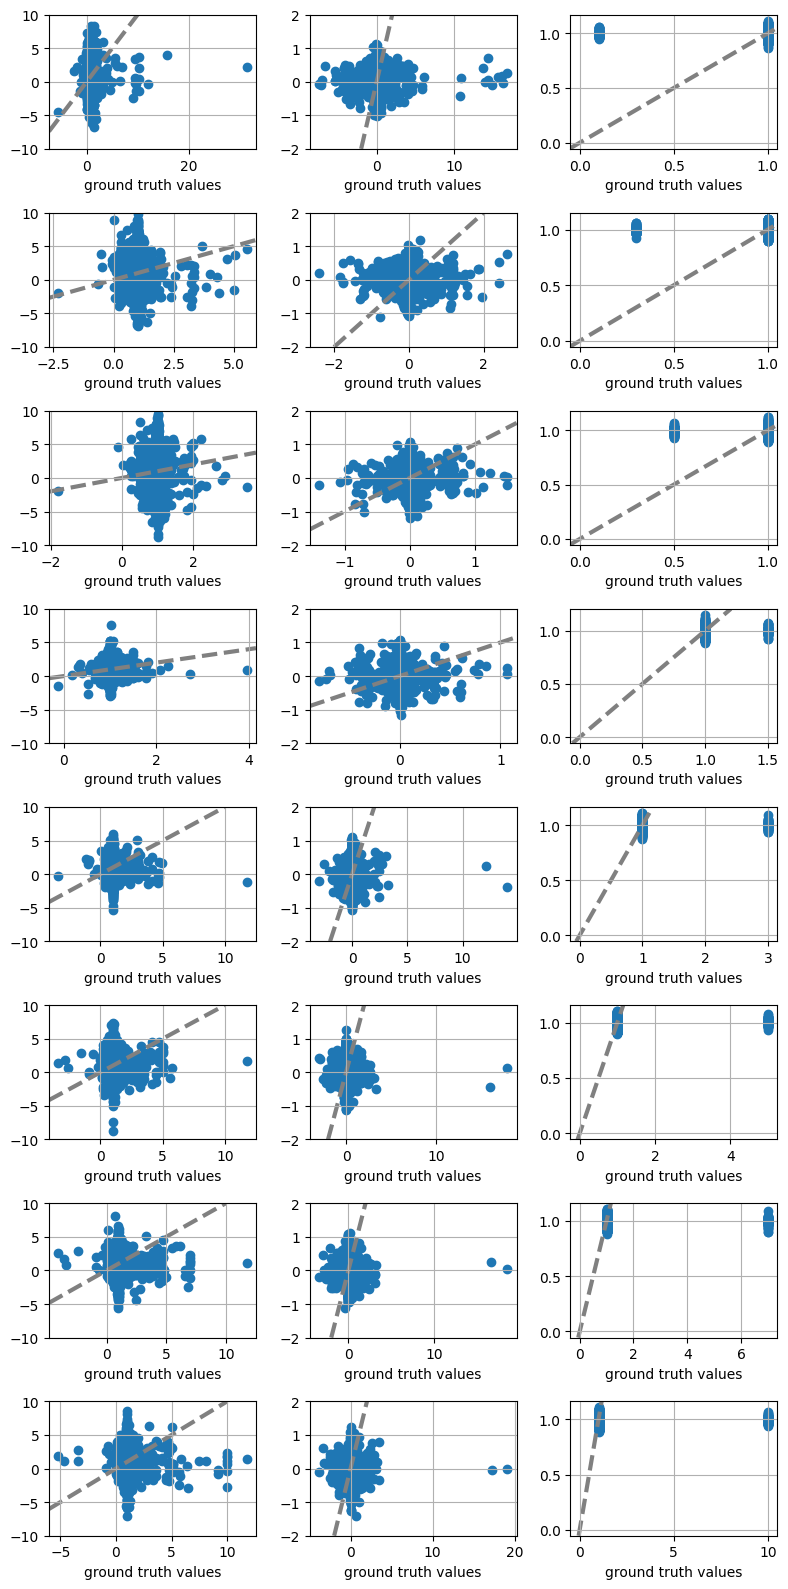

In [21]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(8, 3, figsize=(8,16))

for i in range(8):

    # ax[i,0].set_aspect('equal', 'datalim')
    ax[i,0].scatter(bmca_objs[i].vn.values, v_ppcs[i].values.reshape((68,-1)))
    ax[i,0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,0].set_title('v_obs, ground truth vs. posterior predictive')
    ax[i,0].set_xlabel('ground truth values')
    # ax[i,0].set_ylabel('predicted values')
    ax[i,0].grid()
    ax[i,0].set_ylim((-10,10))

    # ax[i,1].set_aspect('equal', 'datalim')
    ax[i,1].scatter(bmca_objs[i].xn.values, x_ppcs[i].values.reshape((64,-1)))
    ax[i,1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,1].set_title('chi_obs, ground truth vs. posterior predictive')
    ax[i,1].set_xlabel('ground truth values')
    ax[i,1].grid()
    ax[i,1].set_ylim((-2,2))

    # ax[i,1].set_aspect('equal', 'datalim')
    ax[i,2].scatter(bmca_objs[i].en.values, e_ppcs[i].values.reshape((68,-1)))
    ax[i,2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,1].set_title('e_obs, ground truth vs. posterior predictive')
    ax[i,2].set_xlabel('ground truth values')
    ax[i,2].grid()

f.tight_layout()

# f.suptitle('BMCA on Topology C by perturbation, allData')

### Elasticity check 

In [10]:
Ex01_advi = util.get_az_summary(trace01)
Ex03_advi = util.get_az_summary(trace03)
Ex05_advi = util.get_az_summary(trace05)

Ex15_advi = util.get_az_summary(trace15)
Ex3_advi = util.get_az_summary(trace3)
Ex5_advi = util.get_az_summary(trace5)
Ex7_advi = util.get_az_summary(trace7)
Ex100_advi = util.get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [14]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                Ex01_advi, Ex03_advi, 
                               Ex05_advi, Ex15_advi, Ex3_advi, Ex5_advi, 
                               Ex7_advi, Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyC-noReg_allData_elasticities.csv')

In [15]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

(-10.0, 10.0)

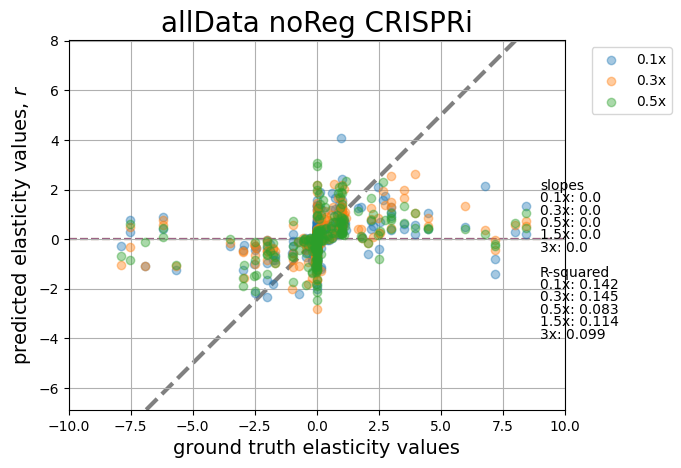

In [29]:
plt.axes().set_aspect('equal', 'datalim')
# plt.scatter(elasticities_df['gt'], elasticities_df['knockout'], alpha=0.4, label='knockout', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 9
line_spacing = 0.5
slope_start = 2
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

plt.xlim(-10,10)

(-10.0, 10.0)

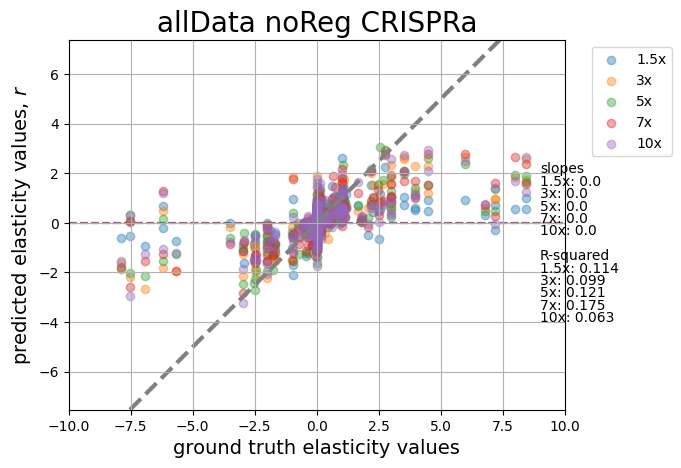

In [36]:
plt.axes().set_aspect('equal', 'datalim')
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 9
line_spacing = 0.5
slope_start = 2
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[3:8]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+3]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[3:8]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+3]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+3]), slope=e_slopes[i+3], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

plt.xlim(-10,10)

In [16]:
# make elasticity df with the high elasticities removed 
elasticities_df_lt10 = elasticities_df[abs(elasticities_df['gt'])<10]
# then calculate the slope, intercepts, and r2s
e_slopes_lt10 = [round(util.calculate_slope(elasticities_df_lt10['gt'], elasticities_df_lt10[i])[0],3) for i in pt_labels]
e_intercepts_lt10 = [round(util.calculate_slope(elasticities_df_lt10['gt'], elasticities_df_lt10[i])[1],3) for i in pt_labels]
e_r2s_lt10 = [round(util.calculate_slope(elasticities_df_lt10['gt'], elasticities_df_lt10[i])[2],3) for i in pt_labels]

(-10.0, 10.0)

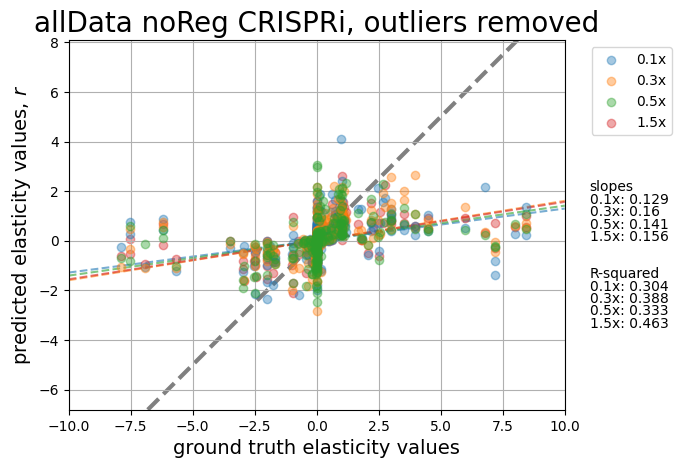

In [29]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['0.5x'], alpha=0.4, label='0.5x', zorder=10)
plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['1.5x'], alpha=0.4, label='1.5x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData noReg CRISPRi, outliers removed', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 11
line_spacing = 0.5
slope_start = 2
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:4]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes_lt10[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:4]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s_lt10[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(4):
    plt.axline((0, e_intercepts_lt10[i]), slope=e_slopes_lt10[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

plt.xlim(-10,10)

(-10.0, 10.0)

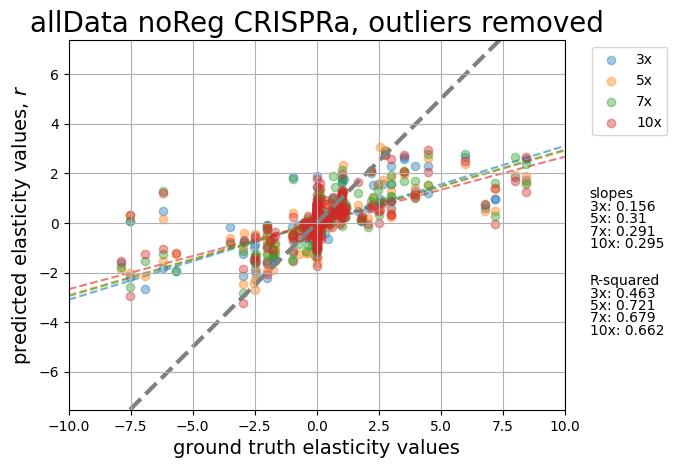

In [31]:
plt.axes().set_aspect('equal', 'datalim')

# plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df_lt10['gt'], elasticities_df_lt10['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRa, outliers removed', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 11
line_spacing = 0.5
slope_start = 1
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[4:8]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes_lt10[i+3]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[4:8]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s_lt10[i+3]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(4):
    plt.axline((0, e_intercepts_lt10[i+4]), slope=e_slopes_lt10[i+4], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

plt.xlim(-10,10)

In [32]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt        0.000000
0.1x    166.669676
0.3x    166.661009
0.5x    166.659426
1.5x    166.634969
3x      166.623979
5x      166.642417
7x      166.652031
10x     166.665175
dtype: float64

In [34]:
MAE_lt10 = abs(elasticities_df_lt10.sub(elasticities_df_lt10['gt'], axis=0)).sum()/len(elasticities_df_lt10['gt'])
MAE_lt10

gt      0.000000
0.1x    0.097443
0.3x    0.088593
0.5x    0.085776
1.5x    0.061642
3x      0.054618
5x      0.071849
7x      0.083328
10x     0.095912
dtype: float64

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

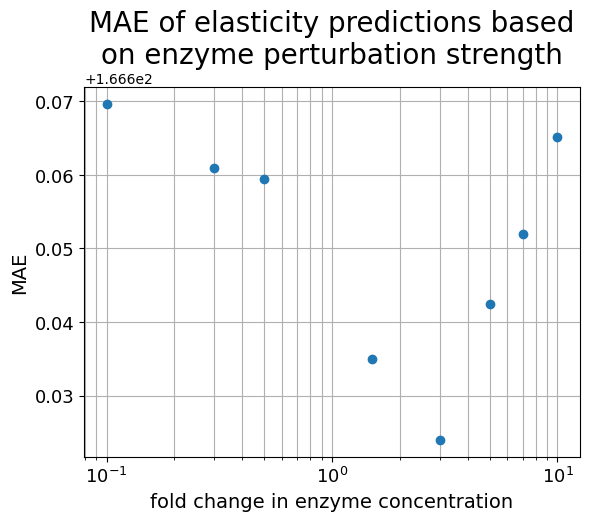

In [68]:
plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength\n(outliers removed)')

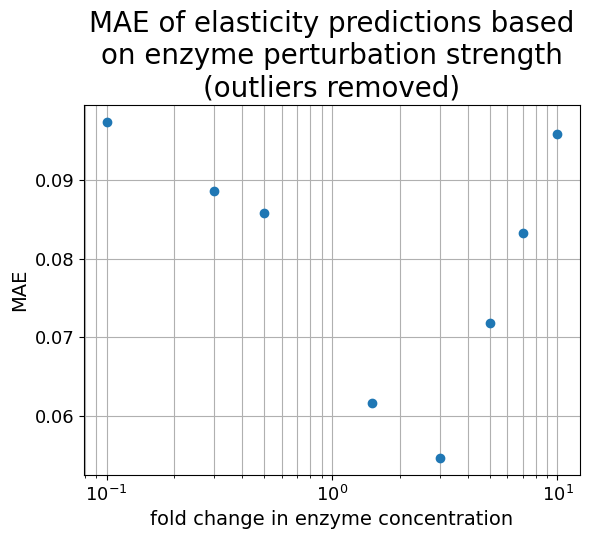

In [71]:
plt.scatter(pt_levels, MAE_lt10[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength\n(outliers removed)", size=20)

In [38]:
uu = pd.concat([MAE, MAE_lt10], axis=1)
uu.columns = ['untrimmed', 'lt10']
uu.to_csv('topologyC_allData_MAE.csv')

## Calculating FCCs

In [18]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

## Negative predictions

In [19]:
Ex01_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex03_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj03)['prior']['Ex'])
Ex05_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj05)['prior']['Ex'])

Ex15_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj15)['prior']['Ex'])
Ex3_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj3)['prior']['Ex'])
Ex5_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj5)['prior']['Ex'])
Ex7_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj7)['prior']['Ex'])
Ex100_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj100)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

In [46]:
# there are 66 perturbations + 1 ref state
# there are 68 enzymes
# Ex is supposed to be (68, 64) 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [112]:
# automatic padding for en + vn
for i, obj in enumerate(bmca_objs):
    perturbation = pt_levels[i]
    new_en_arr = obj.en.values
    new_vn_arr = obj.vn.values
    vn_padding = [1]*68

    pt_idx = np.where((new_en_arr==perturbation).any(0))[0]
    no_pt_idx = list(set(range(68)).difference(set(pt_idx)))

    while (len(no_pt_idx) != 0):    
        en_padding = [1]*68
        en_padding[no_pt_idx[0]] = perturbation
        new_en_arr = np.insert(new_en_arr, no_pt_idx[0] + 1, en_padding, axis=0) 
        new_vn_arr = np.insert(new_vn_arr, no_pt_idx[0] + 1, vn_padding, axis=0) 
        pt_idx = np.where((new_en_arr==perturbation).any(0))[0]
        no_pt_idx = list(set(range(68)).difference(set(pt_idx)))
    obj.en = pd.DataFrame(new_en_arr[1:], columns=obj.en.columns)
    obj.vn = pd.DataFrame(new_vn_arr[1:], columns=obj.vn.columns)

In [115]:
priorFCC01 = util.estimate_CCs(BMCA_obj01, Ex01_prior.reshape((68,-1)))
priorFCC03 = util.estimate_CCs(BMCA_obj03, Ex03_prior.reshape((68,-1)))
priorFCC05 = util.estimate_CCs(BMCA_obj05, Ex05_prior.reshape((68,-1)))

priorFCC15 = util.estimate_CCs(BMCA_obj15, Ex15_prior.reshape((68,-1)))
priorFCC3 = util.estimate_CCs(BMCA_obj3, Ex3_prior.reshape((68,-1)))
priorFCC5 = util.estimate_CCs(BMCA_obj5, Ex5_prior.reshape((68,-1)))
priorFCC7 = util.estimate_CCs(BMCA_obj7, Ex7_prior.reshape((68,-1)))
priorFCC100 = util.estimate_CCs(BMCA_obj100, Ex100_prior.reshape((68,-1)))


In [ ]:
postFCC01 = util.estimate_CCs(BMCA_obj01, Ex01_advi.reshape((68,-1)))
postFCC03 = util.estimate_CCs(BMCA_obj03, Ex03_advi.reshape((68,-1)))
postFCC05 = util.estimate_CCs(BMCA_obj05, Ex05_advi.reshape((68,-1)))

postFCC15 = util.estimate_CCs(BMCA_obj15, Ex15_advi.reshape((68,-1)))
postFCC3 = util.estimate_CCs(BMCA_obj3, Ex3_advi.reshape((68,-1)))
postFCC5 = util.estimate_CCs(BMCA_obj5, Ex5_advi.reshape((68,-1)))
postFCC7 = util.estimate_CCs(BMCA_obj7, Ex7_advi.reshape((68,-1)))
postFCC100 = util.estimate_CCs(BMCA_obj100, Ex100_advi.reshape((68,-1)))

In [20]:
prior_FCCs = [priorFCC01, priorFCC03, priorFCC05, priorFCC15, priorFCC3, priorFCC5, priorFCC7, priorFCC100]
post_FCCs = [postFCC01, postFCC03, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]


In [ ]:
prd_priorFCCs = pd.concat([util.append_FCC_df(prior_FCCs[i], pt_labels[i],r) for i in range(len(prior_FCCs))])
prd_postFCCs = pd.concat([util.append_FCC_df(post_FCCs[i], pt_labels[i],r) for i in range(len(post_FCCs))])

## Evaluating FCC ranking

In [49]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v_ACE_OUT']

### via Spearman rank coefficients

In [25]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v_ACE_OUT', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [ ]:
pt_labels = [i+'-prior' for i in pt_labels] + [i+'-post' for i in pt_labels]

In [35]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

In [29]:
spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyC_allData_spr.csv')

In [ ]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']*10 + ['b']*10)
plt.grid()

for i, txt in enumerate(spearman_df['r']):
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color='k')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

_=plt.xticks(rotation=-70,ha='left',rotation_mode="anchor")

### evaluating top 10 rankings

In [26]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v19') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v19')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

In [ ]:
q.to_csv('../../../data/results/rankings/topologyC-noReg_allData_rankings.csv')

In [ ]:
rank_df = pd.read_csv('../../../data/results/rankings/topologyC-noReg_allData_rankings.csv')

In [ ]:
topTen_df = rank_df[rank_df['v19'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

In [ ]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)